In [64]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set()

#Importing required modules
from sklearn.cluster import KMeans

pizza_df = pd.read_csv('pizza_clean.csv')
cities_df = pd.read_csv('cities_clean.csv')
rando = 120

We will prefix rando as a seed for any ML involved in future steps. This is to regenerate consistent random results.



## Perform k-means clustering

Now we will apply k-means clustering on the pizza dataset. We will set it at a default of **10 clusters** for now. We will find the optimal number of clusters later on through inertia.

We will use inertia/sum of square error as the cost function for k-means. It measures the Euclidian distance between a centroid and a datapoint, squaring it. It will then assigning the datapoint to a centroid with the lowest inertia. This is done for all our datapoints. 

Subsequently, the centroids will be shifted to reduce total inertia summed up across all assigned datapoints before performing the previous step again. This will run recursively until every centroid barely moves, indicating the optimisation of cost function.

## Example

We will assign the first 50 datapoints to their cluster as shown below in a list. Do note that the assigned cluster is the final cluster assigned after multiple iterations of the process. 

In [65]:
kmeans = KMeans(n_clusters = 10, random_state = rando)
cluster = pd.DataFrame(pizza_df[["longitude","latitude"]])
# cluster.shape
label = kmeans.fit_predict(cluster)
print(label[:50])

[4 1 9 9 2 7 8 9 1 6 0 2 4 8 2 8 9 7 2 4 1 2 9 3 2 2 1 6 2 2 1 9 1 4 1 0 9
 4 4 1 3 8 0 2 4 2 2 2 2 1]


Here we see how the first 50 datapoints have been assigned to their respective centroid.

For example, the shop in the first row has been assigned to cluster 4. The next shop is assigned to cluster 1, then 9 etc

In [66]:
pizza_df['Cluster'] = label

We will also append the centroid each datapoint has been assigned to into the dataframe.

For further illustration, below contains all the pizza shops assigned to cluster 0

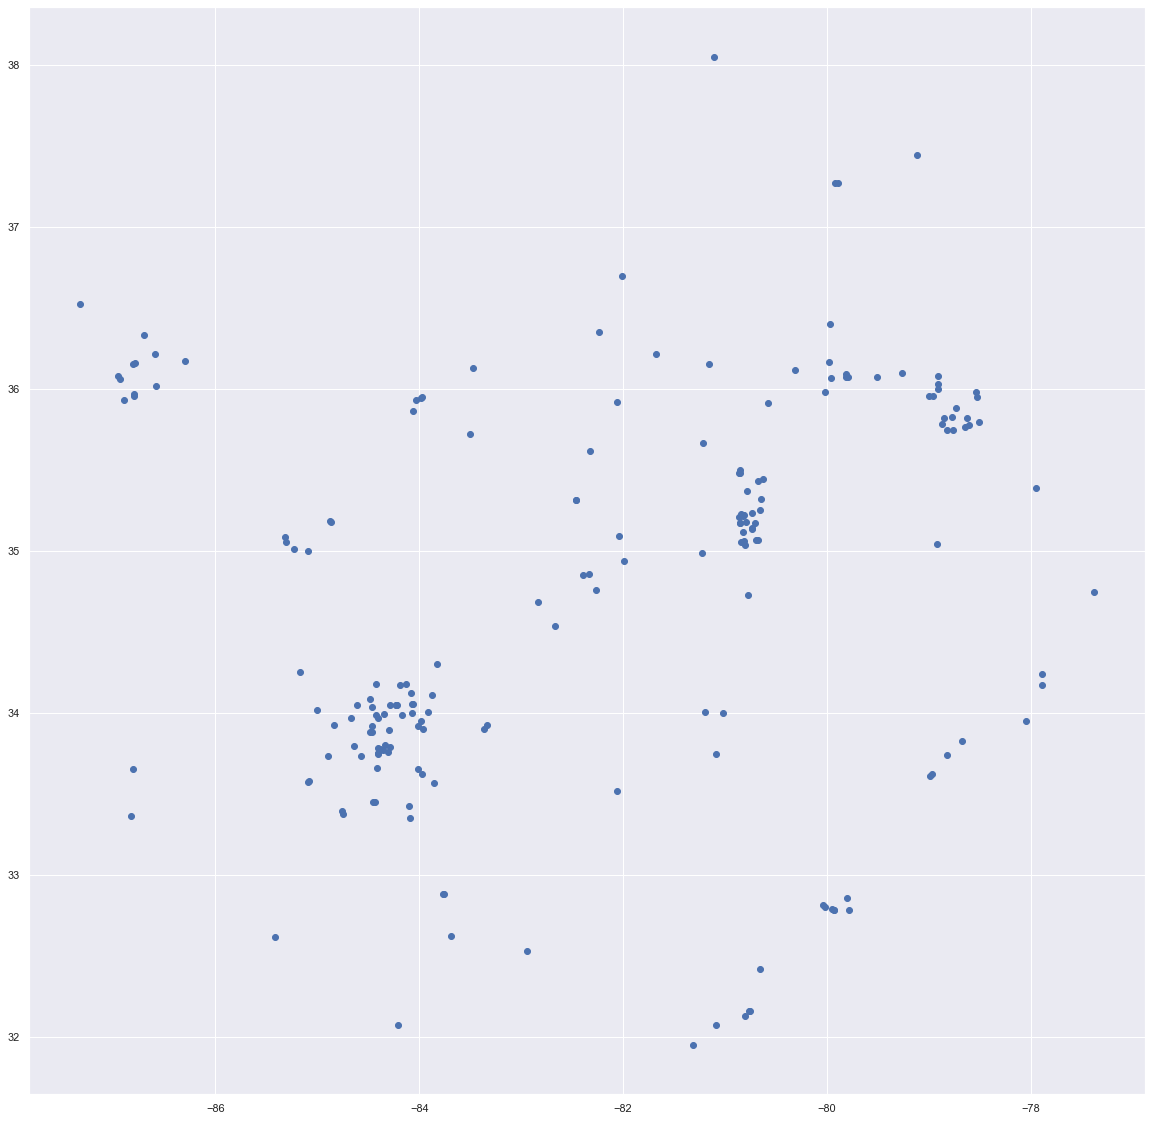

In [67]:
f, axes = plt.subplots(figsize=(20,20))
#filter rows of original data
filtered_label0 = pizza_df[label == 0]
#print(filtered_label0)
#plotting the results
plt.scatter(filtered_label0["longitude"] , filtered_label0["latitude"])
plt.show()

## Given 10 clusters, this is how the datapoints will be categorised

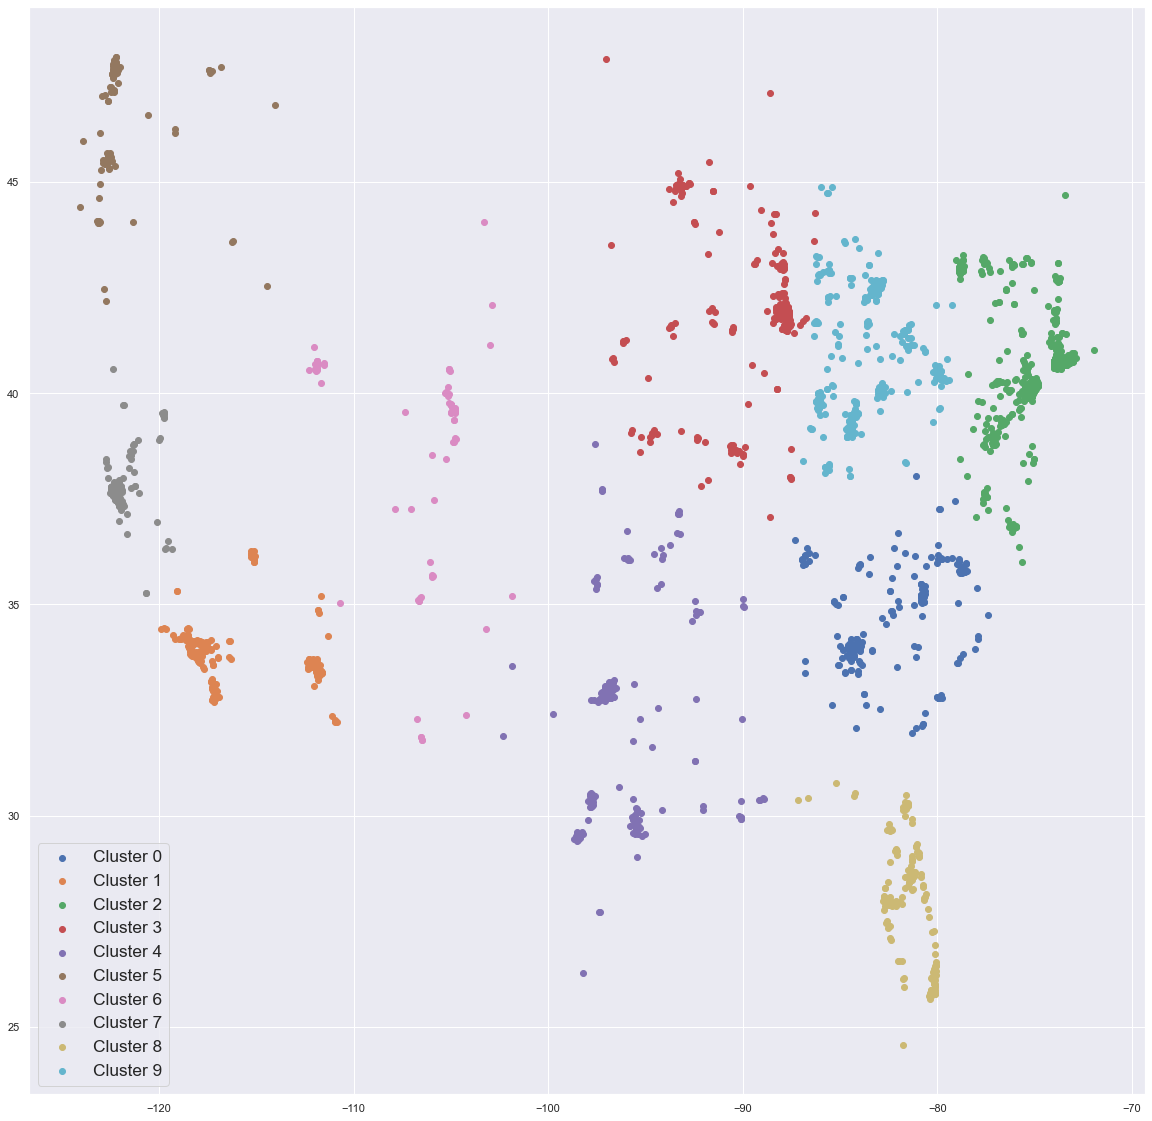

In [68]:
labels = np.unique(label)
f, axes = plt.subplots(figsize=(20,20))

for l in labels:
    filtered_label = pizza_df[label == l]
    plt.scatter(filtered_label["longitude"] , filtered_label["latitude"], label = "Cluster " + str(l))

plt.legend(fontsize = 'x-large')

However, as we have performed this on a predetermined number of clusters (10), it may not produce the optimal result. 

With this in mind, we will plot the total inertia against number of clusters selected. While the total inertia will definitely go down as the number of clusters increase, we do not want too many clusters as well. Hence, we will find the "sweet-spot" by observing the **elbow point**.

To plot this graph, we will calculate the calculate the SSE for every num_of_clusters = i from i = 1 to i = 20.

We will first create a function to calculate the inertia given n number of clusters

In [69]:
def cal_inertia(n):
    cluster = pd.DataFrame(pizza_df[["longitude","latitude"]])
    kmeans = KMeans(n_clusters = n, random_state = rando).fit(cluster)
    kmeans.fit(cluster)

    return kmeans.inertia_

In [70]:
lst = []
max = 20
for i in range(2,max):
    lst.append(cal_inertia(i))

x_axis = list(range(2,max))
y_axis = lst

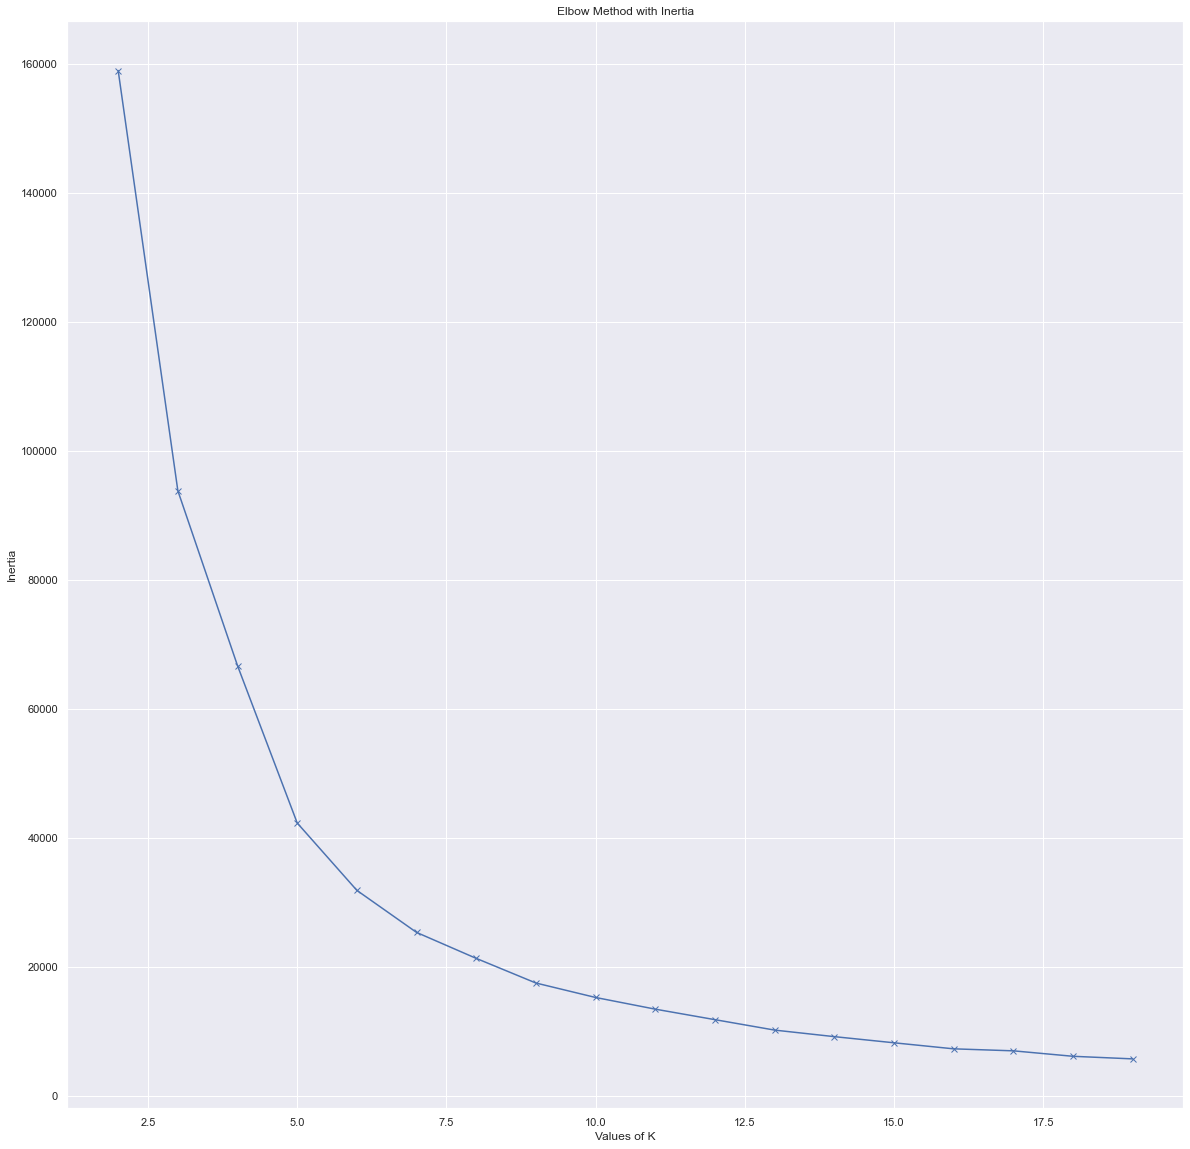

In [71]:
f, axes = plt.subplots(figsize=(20,20))
plt.plot(x_axis, y_axis, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Elbow Method with Inertia')
plt.show()

## By observation, n = 7 produces the best results as Sum of Squared Error (SSE) decreases in a linear fashion thereafter

To ensure our results are accurate, we will also perform distortion on our cluster to find its elbow point.

In [72]:
from scipy.spatial.distance import cdist

distortions = []
mapping1 = {}
K = range(1, 20)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state = rando).fit(cluster)
    kmeanModel.fit(cluster)
  
    distortions.append(sum(np.min(cdist(cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / cluster.shape[0])
  
    mapping1[k] = sum(np.min(cdist(cluster, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / cluster.shape[0]

C:\Users\melvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\melvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


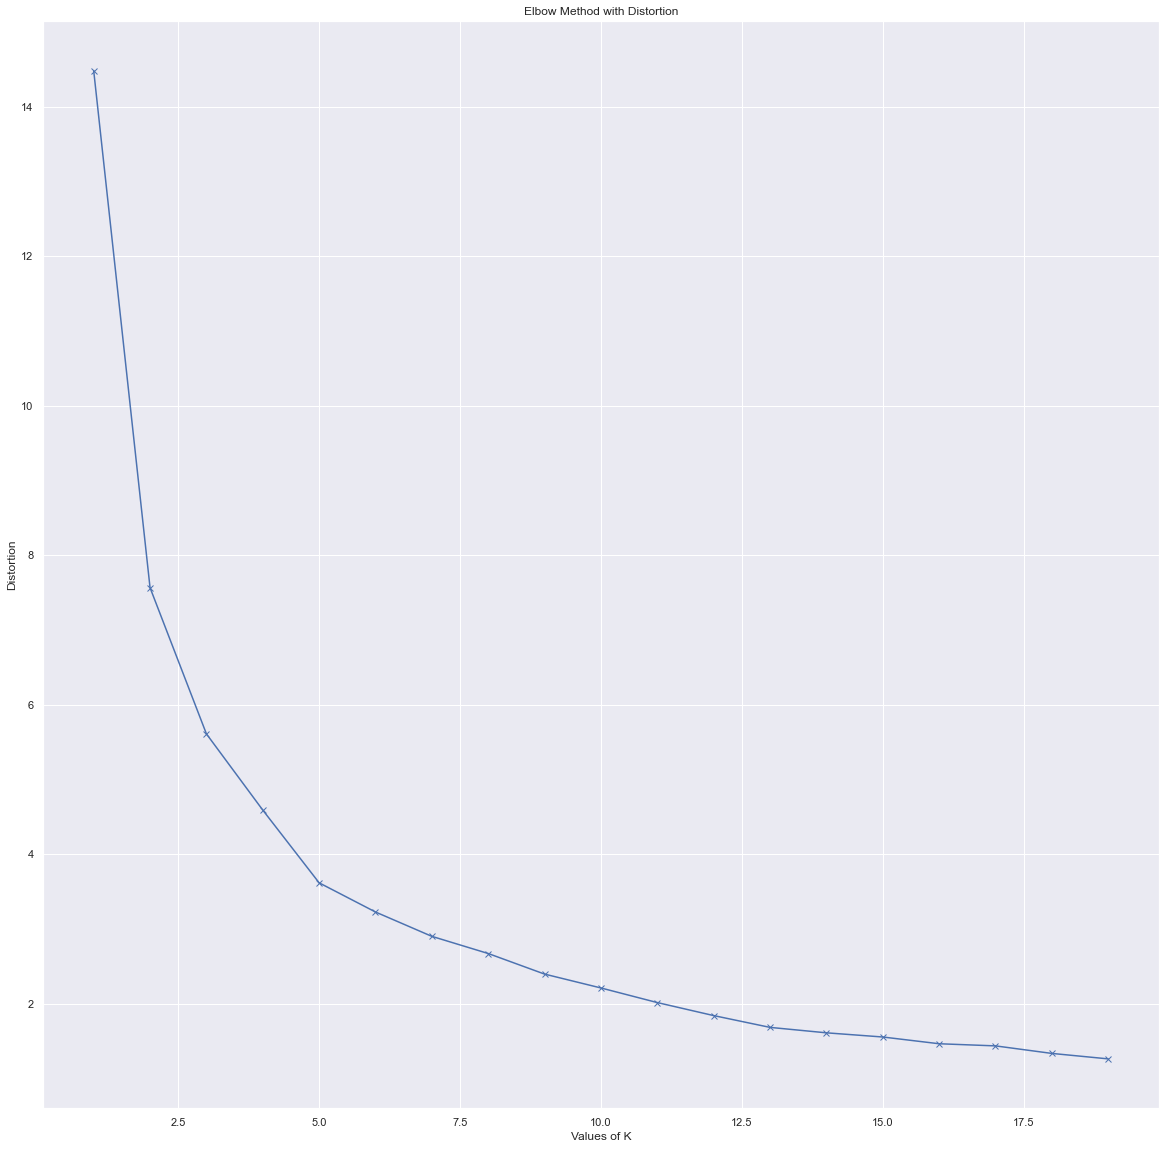

In [73]:
f, axes = plt.subplots(figsize=(20,20))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method with Distortion')
plt.show()

## Similarly, n = 7 produces the best results as the average euclidian squared errors (distance) decreases in a linear fashion thereafter

We will re-cluster the dataset with clusters set to 7 with this conclusion

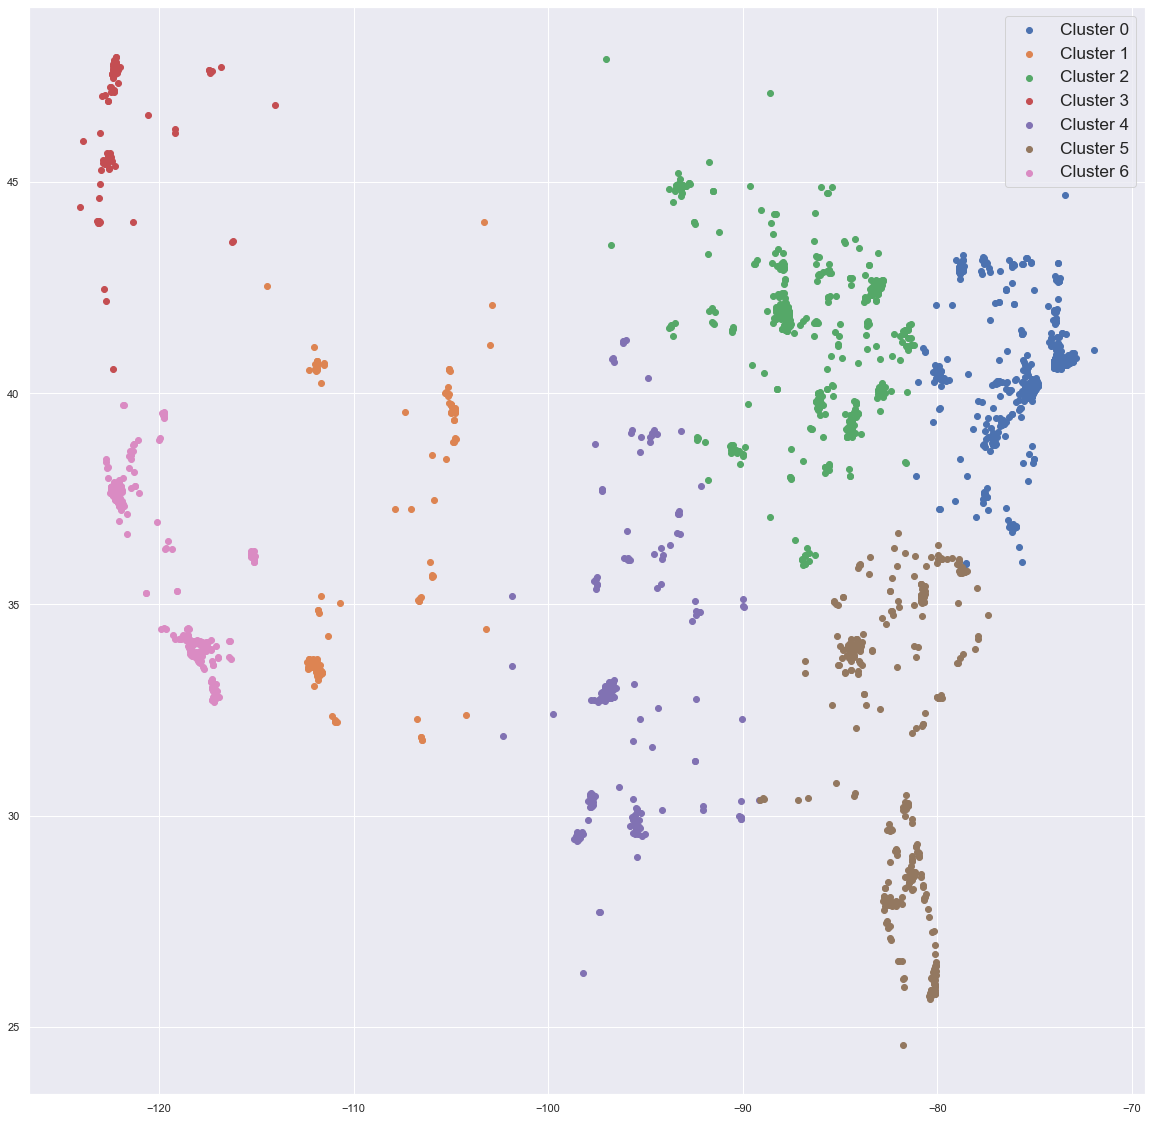

In [74]:
kmeans = KMeans(n_clusters = 7, random_state = rando)
cluster = pd.DataFrame(pizza_df[["longitude","latitude"]])
label = kmeans.fit_predict(cluster)
labels = np.unique(label)
pizza_df['Cluster'] = label
f, axes = plt.subplots(figsize=(20,20))

for l in labels:
    filtered_label = pizza_df[label == l]
    plt.scatter(filtered_label["longitude"] , filtered_label["latitude"], label = "Cluster " + str(l))

plt.legend(fontsize = 'x-large')


Now we will plot out the median prices of each unique pizza joint grouped by their respective clusters

Text(0, 0.5, 'Cluster')

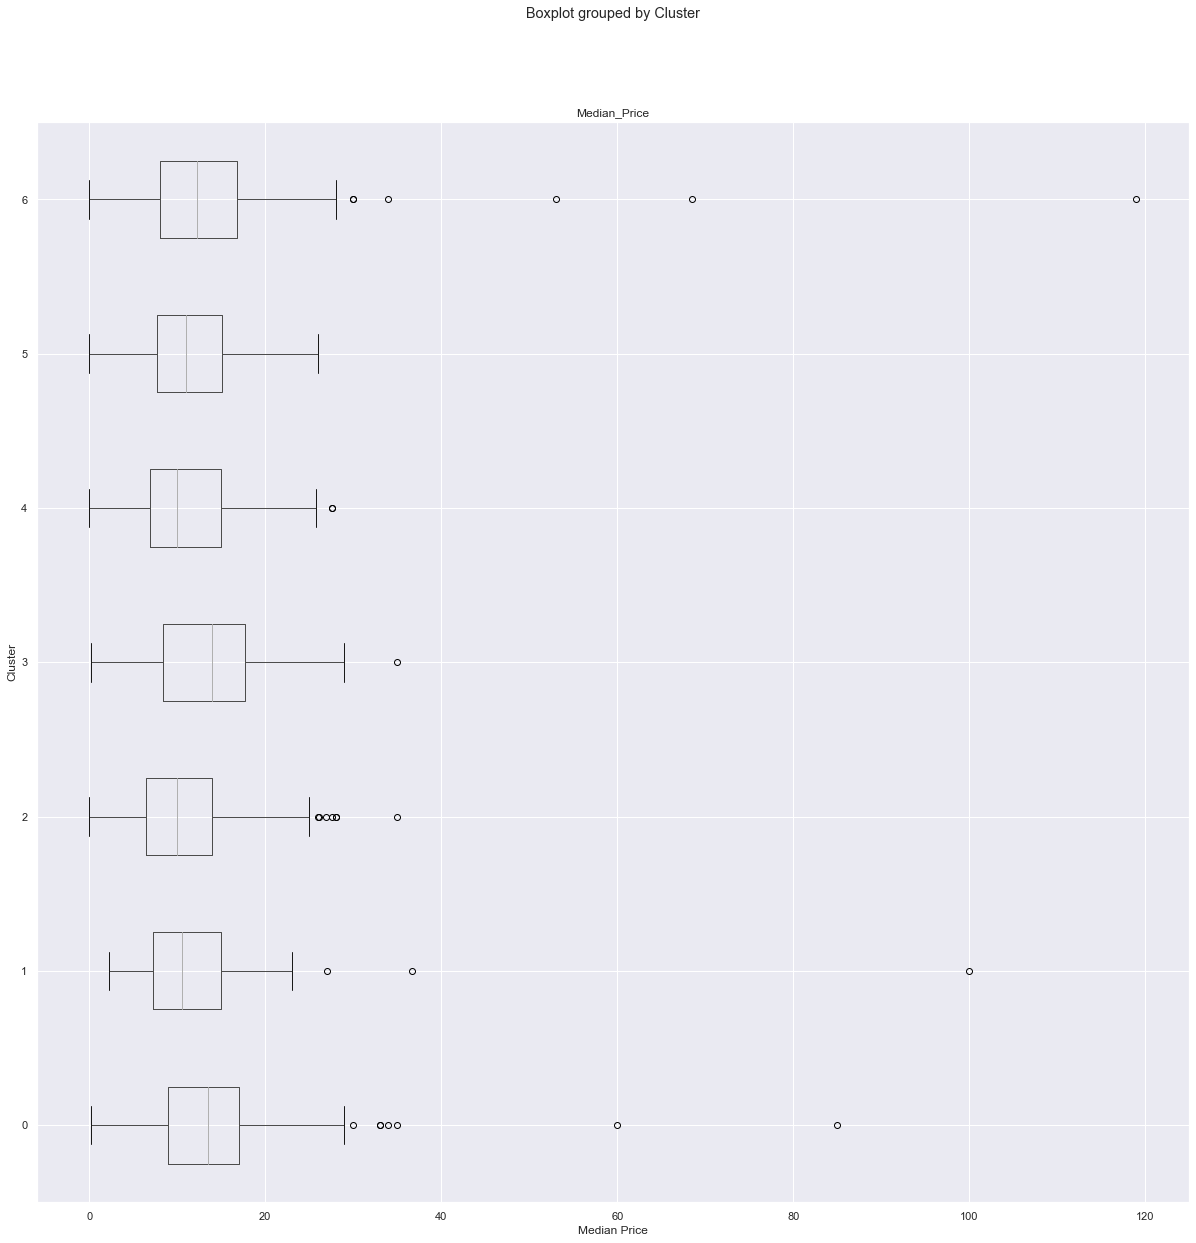

In [75]:
f, axes = plt.subplots(figsize=(20,20))
bplot = pizza_df.boxplot(column = ["Median_Price"], by = 'Cluster', ax = axes, vert = False)
bplot.set_xlabel('Median Price')
bplot.set_ylabel('Cluster')

## Now we will remove the outliers for each cluster to analyse the distribution of median prices within each cluster

In [76]:
def create_df(cluster_num):
    return pd.DataFrame(pizza_df[pizza_df["Cluster"] == cluster_num])
lst_of_frames = []
for i in range(7):
    lst_of_frames.append(create_df(i))


In [77]:
def remove_outlier(df, var):
    Q1_var = df[var].quantile(0.25)
    Q3_var = df[var].quantile(0.75)
    IQR_var = Q3_var - Q1_var
    orig_size = len(df)
    df = df[(df[var] > (Q1_var - 1.5 * IQR_var)) & (df[var] < (Q3_var + 1.5 * IQR_var))]
    print("Outliers removed: ", orig_size - len(df)) 
    
    return (df)

In [78]:
for cluster in range(7):
    lst_of_frames[cluster] = remove_outlier(lst_of_frames[cluster], "Median_Price")
    print("Num of datapoints: ",len(lst_of_frames[cluster]))
    print()



Outliers removed in:  7
Num of datapoints:  706

Outliers removed in:  3
Num of datapoints:  142

Outliers removed in:  7
Num of datapoints:  498

Outliers removed in:  1
Num of datapoints:  91

Outliers removed in:  2
Num of datapoints:  204

Outliers removed in:  0
Num of datapoints:  340

Outliers removed in:  6
Num of datapoints:  267



Having removed the outliers, we will now plot the box plots again for comparision

In [79]:
result = pd.concat(lst_of_frames)

<AxesSubplot:title={'center':'Median_Price'}, xlabel='Median Price', ylabel='Cluster'>

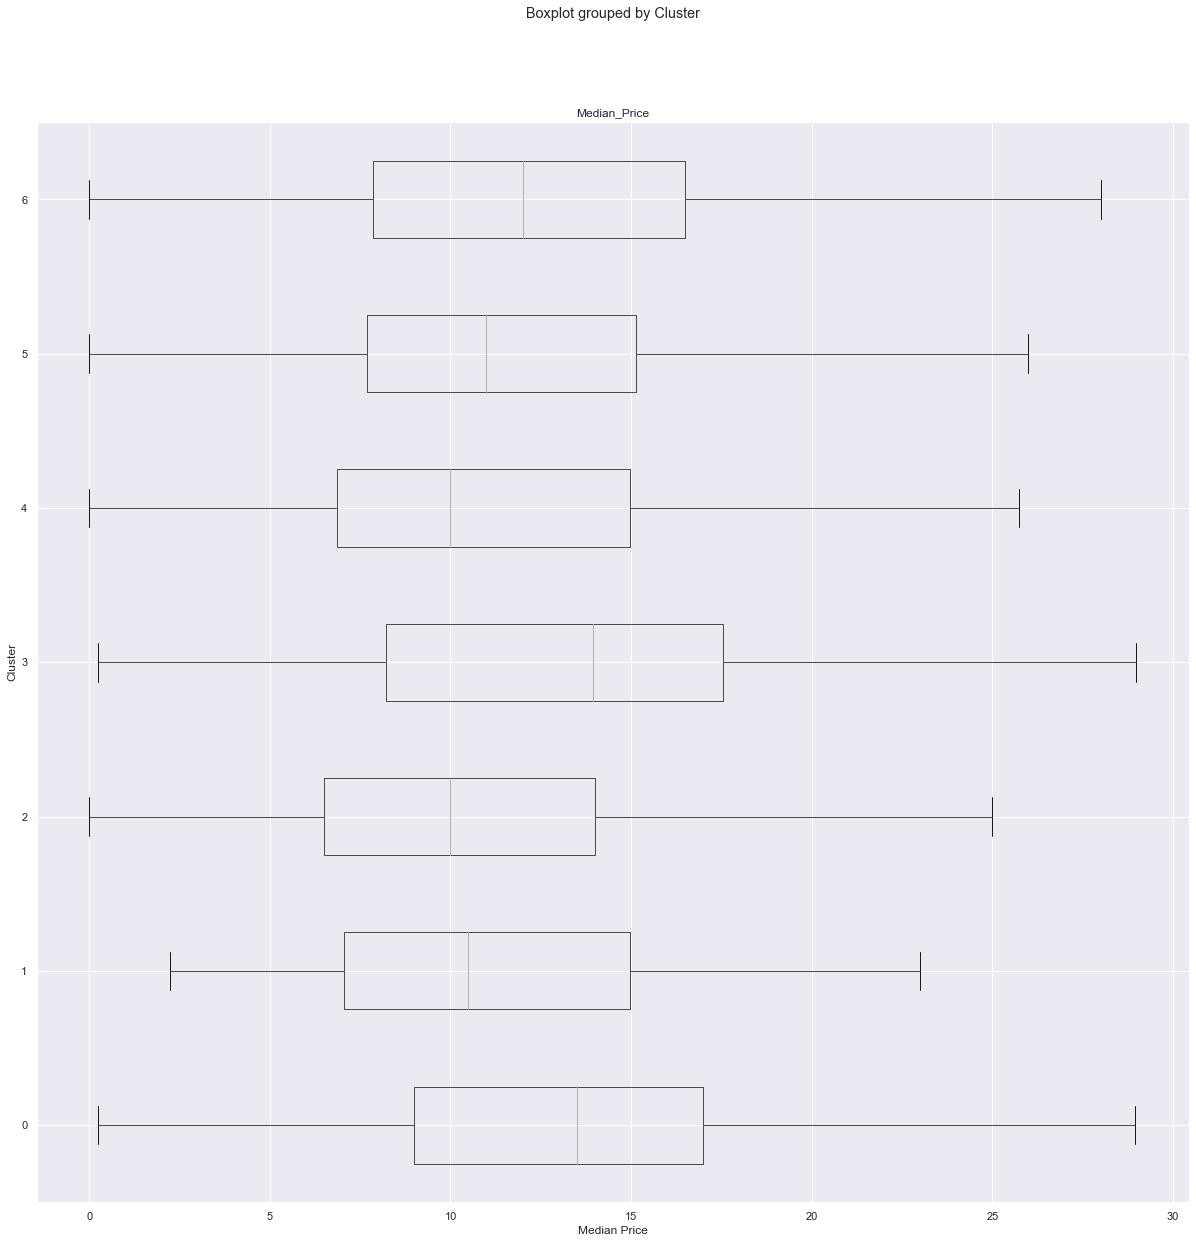

In [80]:
f, axes = plt.subplots(figsize=(20,20))
bplot = result.boxplot(column = ["Median_Price"], by = 'Cluster', ax = axes, vert = False)
bplot.set_xlabel('Median Price')
bplot.set_ylabel('Cluster')
bplot

### Now that we know how to price our pizzas, we need to find out where is a good location to place it. We will determine this by the populations of the top 300 cities


We will first generate the centroids of each cluster as shown below

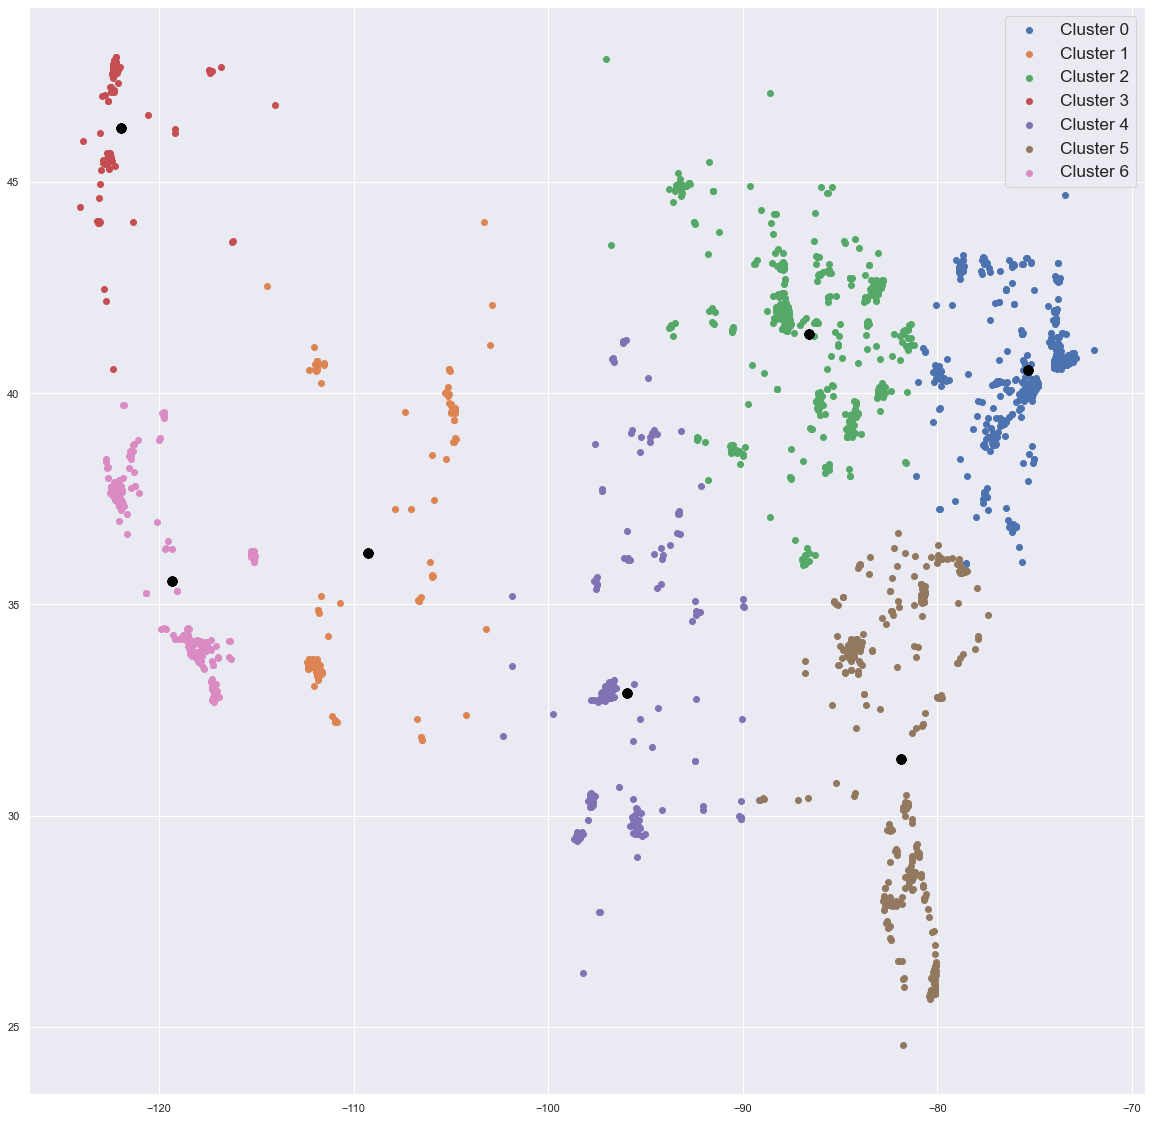

In [86]:
f, axes = plt.subplots(figsize=(20,20))
for l in labels:
    filtered_label = pizza_df[label == l]
    plt.scatter(filtered_label["longitude"] , filtered_label["latitude"], label = "Cluster " + str(l))
    centroids = kmeans.cluster_centers_
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=80, c='black')

plt.legend(fontsize = 'x-large')


### Now we will assign each city to a centroid depending on which is the closest

We will achieve this by calculating the distance between a city and centroid, then assigning the city to its closest centroid by attaching a 'cluster' column to the dataframe

In [88]:
centroids = kmeans.cluster_centers_
[print("Cluster " , index , ":" , centroids[index][0] , centroids[index][1]) for index in range(0,7)]

Cluster  0 : -75.34009069021039 40.565674663786815
Cluster  1 : -109.27271676896552 36.211810453517245
Cluster  2 : -86.60081308287128 41.40399485017822
Cluster  3 : -121.94233069673913 46.283697222391304
Cluster  4 : -95.96173641393204 32.910459388446604
Cluster  5 : -81.86479602979412 31.33077280732353
Cluster  6 : -119.33002543076923 35.54758894362637


[None, None, None, None, None, None, None]

Above are the coordinates of each cluster, in latitude longitude form. With this, we can then calculate the euclidean distance between a city and each centroid, then select the closest centroid to assign the city to.

In [100]:
from math import dist

def find_closest_centroid (datapoint):
    distance = []
    for index in range(0,7):
        distance.append(dist((datapoint[0],datapoint[1]),(centroids[index][0],centroids[index][1])))
        #print(distance)
    return (distance.index(min(distance)))

In [101]:
cluster = []
for row in range(len(cities_df)):
    cluster.append(find_closest_centroid(cities_df.iloc[row,12:14]))
cities_df["Cluster"] = cluster

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

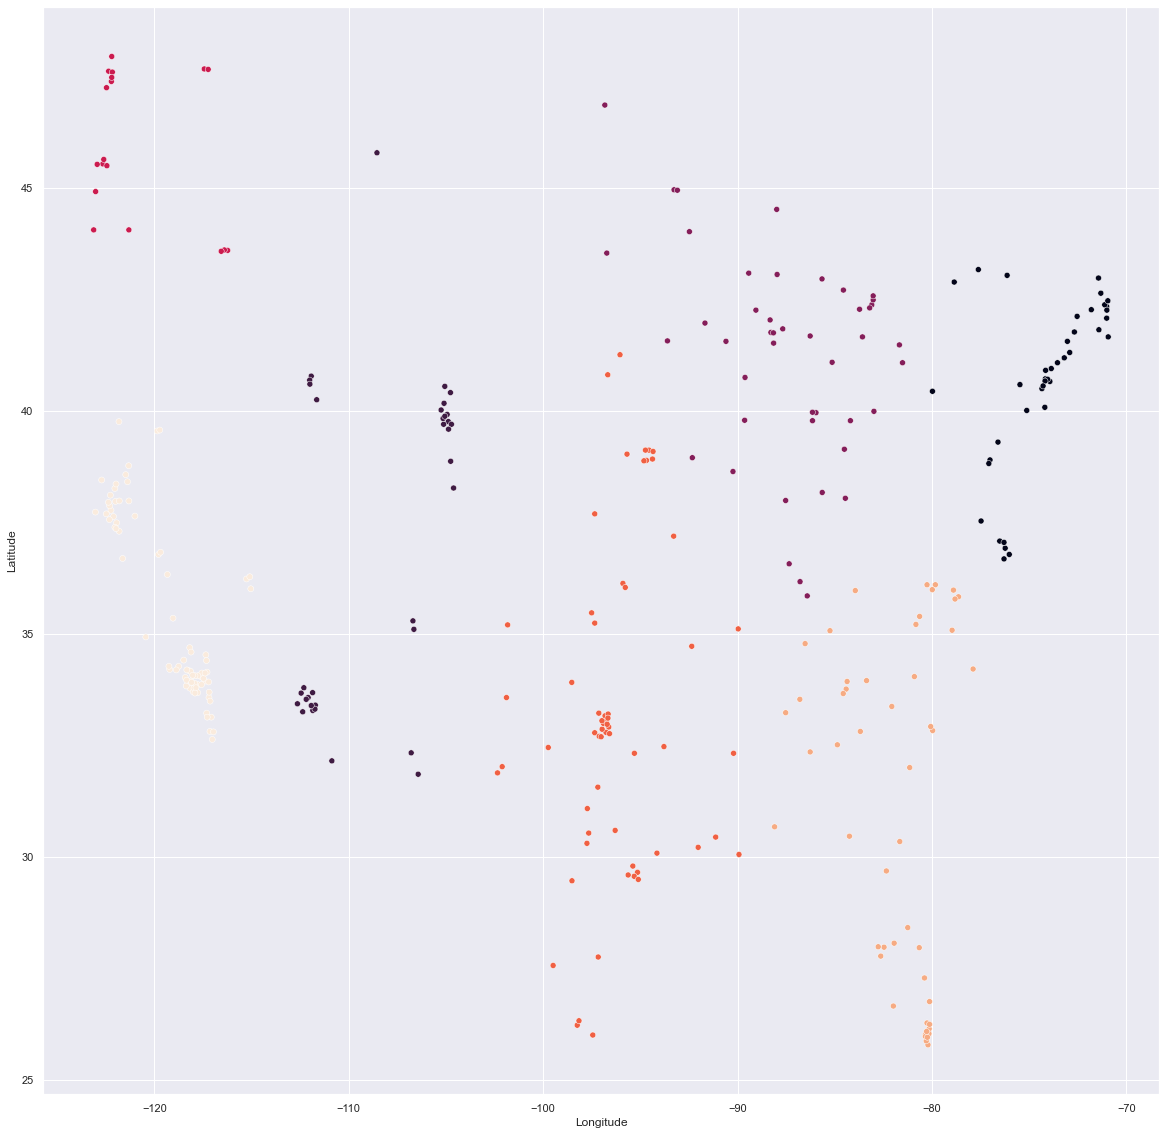

In [103]:
f, axes = plt.subplots(figsize=(20,20))
sb.scatterplot(x=cities_df['Longitude'], y=cities_df['Latitude'], c=cities_df['Cluster'])

Following this, we will sum up the total population within each cluster to evaluate the foot traffic for each region

In [117]:
cluster_pop = [0] * 7
cluster_pop_cities = [0] * 7

for index in range(len(cities_df)):
    clus = cities_df.iloc[index,14] 
    cluster_pop[clus] += cities_df.iloc[index,4]
    cluster_pop_cities[clus] += 1
print(cluster_pop)
#print(cluster_pop_cities)

[18054842, 9425063, 13804773, 3765906, 18610554, 11037975, 21574250]


<AxesSubplot:>

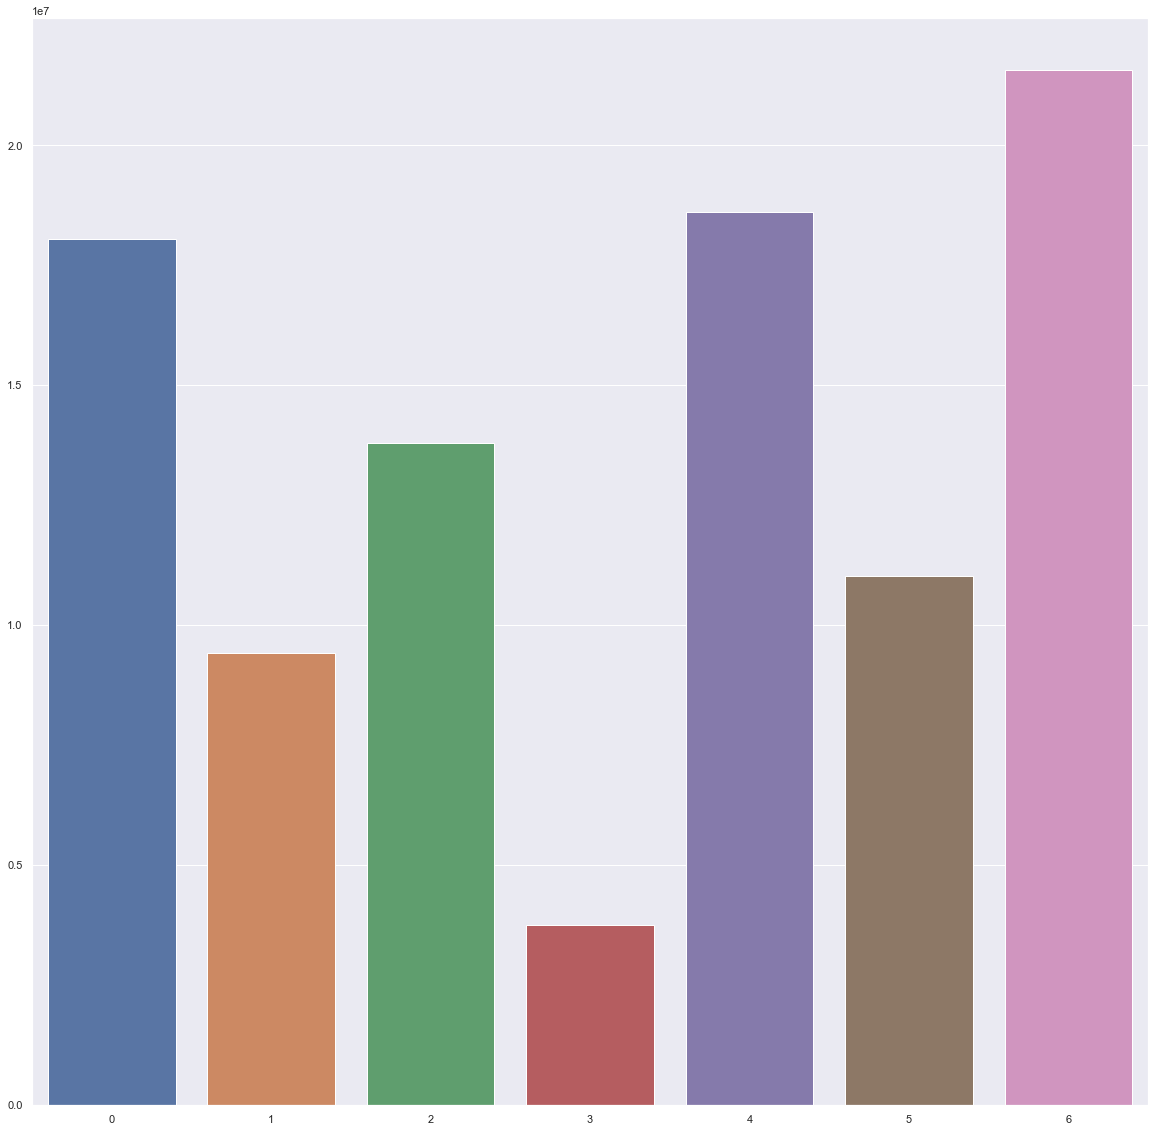

In [118]:
f, axes = plt.subplots(figsize=(20,20))
sb.barplot(x = [0,1,2,3,4,5,6], y = cluster_pop)

Furthermore, we are interested in finding the population density per cluster, which we will calculate by taking the total population / num of pizza shops within each cluster

[25573.43, 66373.68, 27720.43, 41383.58, 91228.21, 32464.63, 80802.43]


<AxesSubplot:>

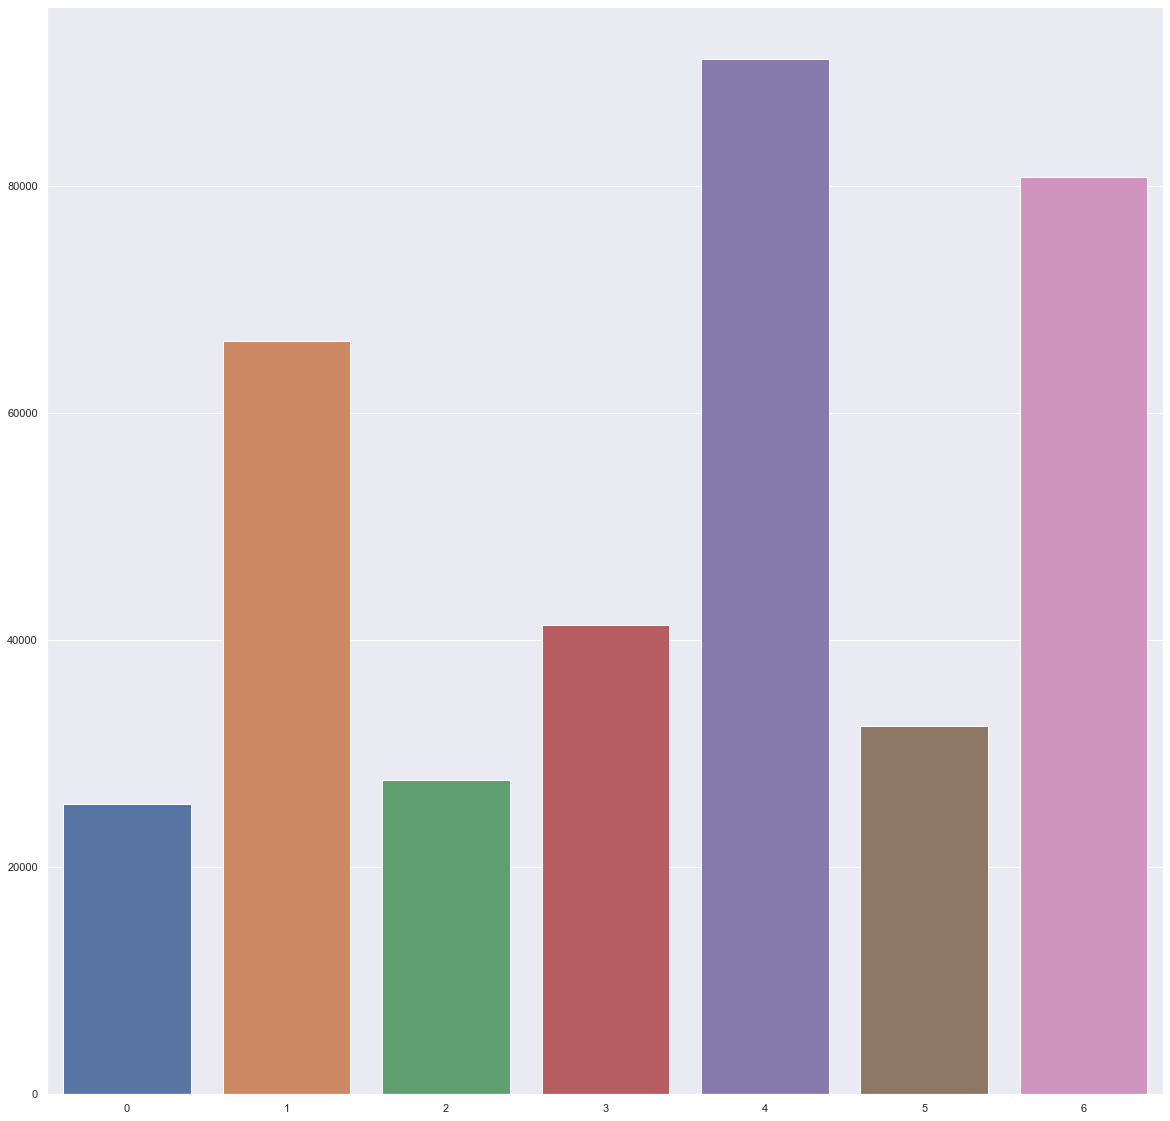

In [119]:
pop_per_shop = [ 0 for i in range(7)]
#print(lst_of_frames)
for cluster in range(7):
    pop_per_shop[cluster] = round(cluster_pop[cluster]/len(lst_of_frames[cluster]),2)

print(pop_per_shop)
f, axes = plt.subplots(figsize=(20,20))
sb.barplot(x = [0,1,2,3,4,5,6], y = pop_per_shop)

Evidently, cluster 4 has the highest pop/shop (91k/shop), indicating a lower level of competition with rival pizza shops (204).
Furthermore, it has the 2nd highest population within this cluster, giving a high level of human traffic (18,610,554) for a franchise to be set up.

Given this cluster, the distribution of median prices of competitors in the region indicates we ought to target ~$10 as a median price to remain price competitive. 